In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## OFI computation
OFI preprocessing and computation is carried out in `order_flow_imbalance/ofi_computation.py` by following the steps below.
1. Clean timestamps according to the date of acquisition: we consider only meaningful timestamps that are within the same day of acquisition.
2. Rescaling prices with the tick size;
3. Compute the quantities $\Delta W$ and $\Delta V$ for each timestamp;
4. Discretizig time and summing the single $e_n$ over the time interval in order to compute OFI, we fix a time interval of 1 min.

In [2]:
ofi = pd.read_csv('../data_cleaned/ofi_10_levels.csv')
OFI_values = ofi.drop(['mid_price_delta', 'time_bin', 'bin_label'], axis=1)

## Distributions
First of all, let us have a look at the time distributions of MLOFI at different levels. The plot below and further analysis suggest that the distributions of MLOFI are quite similar at different levels and that every level is characterized by the presence of outliers which are significantly distant from the mean.

The first observation can be formalized by means of a Kolmogorov-Smirnov test with two samples, while the second observation justifies the usage of a strategy to get rid of outliers that could be present in the distributions.

Text(0, 0.5, 'OFI value')

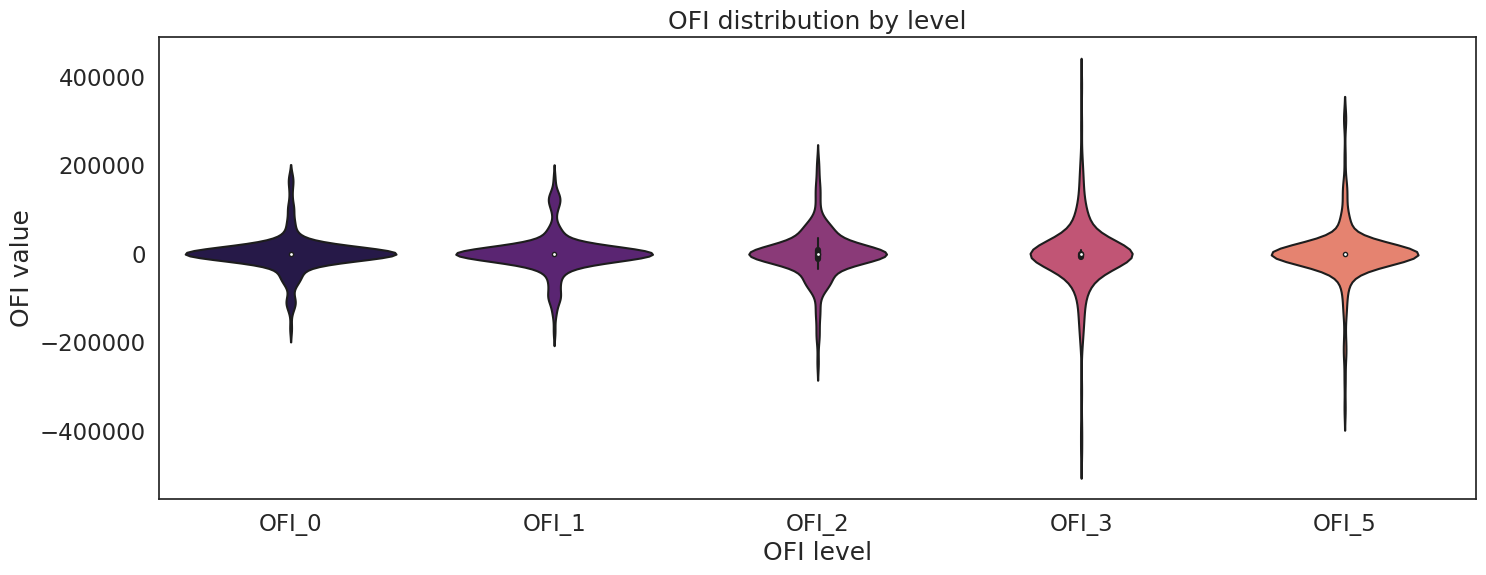

In [3]:
sns.set_theme(style='white', font_scale=1.5, palette = 'magma')
fig, ax = plt.subplots(figsize=(17,6))
df_distr = OFI_values.copy()
df_distr = df_distr.drop(['OFI_9', 'OFI_8', 'OFI_7', 'OFI_6', 'OFI_4'], axis=1)
categorical_ofi = []
levels = []
for c in df_distr.columns:
    categorical_ofi = np.concatenate([categorical_ofi, OFI_values[c]])
    levels = np.concatenate([levels, np.repeat(c, OFI_values.shape[0])])
cat_ofi = pd.DataFrame({'OFI':categorical_ofi, 'level':levels})

sns.violinplot(data=cat_ofi, x='level',y='OFI', ax=ax)
ax.set_title('OFI distribution by level')
ax.set_xlabel('OFI level')
ax.set_ylabel('OFI value')

OFI 0 vs OFI 1: KS distance: 0.04 	 p_value: 1.00
OFI 0 vs OFI 2: KS distance: 0.10 	 p_value: 0.37
OFI 0 vs OFI 3: KS distance: 0.08 	 p_value: 0.62
OFI 0 vs OFI 4: KS distance: 0.06 	 p_value: 0.87
OFI 0 vs OFI 5: KS distance: 0.07 	 p_value: 0.80


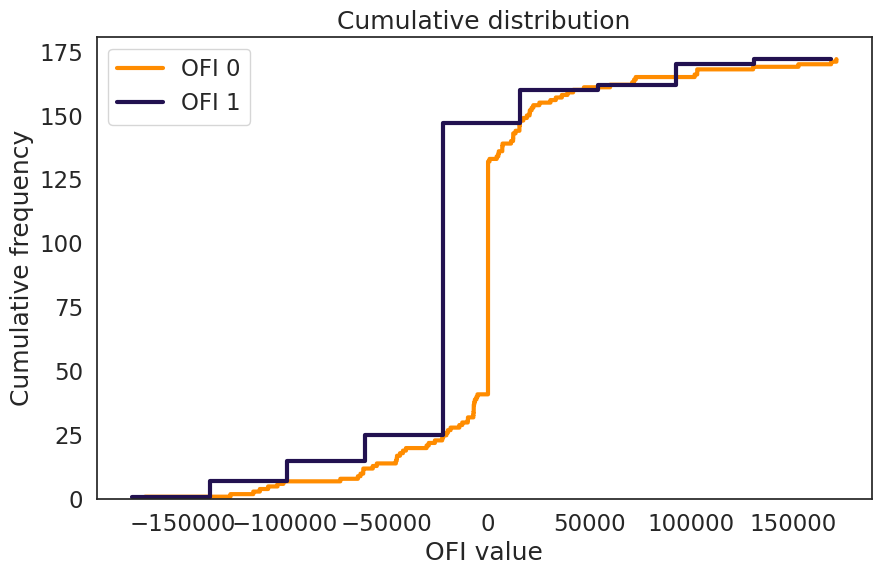

In [4]:
from scipy.stats import ks_2samp

# 0 vs 1
print('OFI 0 vs OFI 1: KS distance: {:.2f} \t p_value: {:.2f}'.format(*ks_2samp(OFI_values['OFI_0'], OFI_values['OFI_1'])))
# 0 vs 2
print('OFI 0 vs OFI 2: KS distance: {:.2f} \t p_value: {:.2f}'.format(*ks_2samp(OFI_values['OFI_0'], OFI_values['OFI_2'] )))
# 0 vs 3
print('OFI 0 vs OFI 3: KS distance: {:.2f} \t p_value: {:.2f}'.format(*ks_2samp(OFI_values['OFI_0'], OFI_values['OFI_3'])))
# 0 vs 4
print('OFI 0 vs OFI 4: KS distance: {:.2f} \t p_value: {:.2f}'.format(*ks_2samp(OFI_values['OFI_0'], OFI_values['OFI_4'])))
# 0 vs 5
print('OFI 0 vs OFI 5: KS distance: {:.2f} \t p_value: {:.2f}'.format(*ks_2samp(OFI_values['OFI_0'], OFI_values['OFI_5'])))

fig, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='white', font_scale=1.5, palette = 'magma')
lw=3
sns.histplot(data=ofi, x='OFI_0', ax=ax, cumulative=True, element = 'step', fill=False, linewidth=lw, label='OFI 0', color='darkorange')
sns.histplot(data=ofi, x='OFI_1', ax=ax, cumulative=True, element = 'step', fill=False, linewidth=lw, label='OFI 1')
ax.set_title('Cumulative distribution')
ax.set_xlabel('OFI value')
ax.set_ylabel('Cumulative frequency')
ax.legend()


## Outlier detection with Isolation Forest and Linear Fit

The OFI, can be a good price predictor since it has been shown (Cont et al., (2011)) that it stands in a linear relation with the midprice, thus with the price at which it is more likely that a trades occur. 

$$ \Delta P_k = \beta \,\, OFI_k + \epsilon$$

where $ \Delta P_k $ is the variation in price at time $\tau_k$, $\beta$ is the price impact coefficient, $OFI_k$ is the order flow imbalance at time $\tau_k$, and $\epsilon$ is the error term.

Here we study not only the first level of the book, but all the first six levels, in order to verify if such linear relation holds for the whole book.

In [5]:
from sklearn.ensemble import IsolationForest
import numpy as np

Fitting level 0
Fitting level 1
Fitting level 2
Fitting level 3
Fitting level 4
Fitting level 5


/tmp/ipykernel_2938/881930061.py:48: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[0,0].get_shared_x_axes().join(ax[0,0], ax[1,0])


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

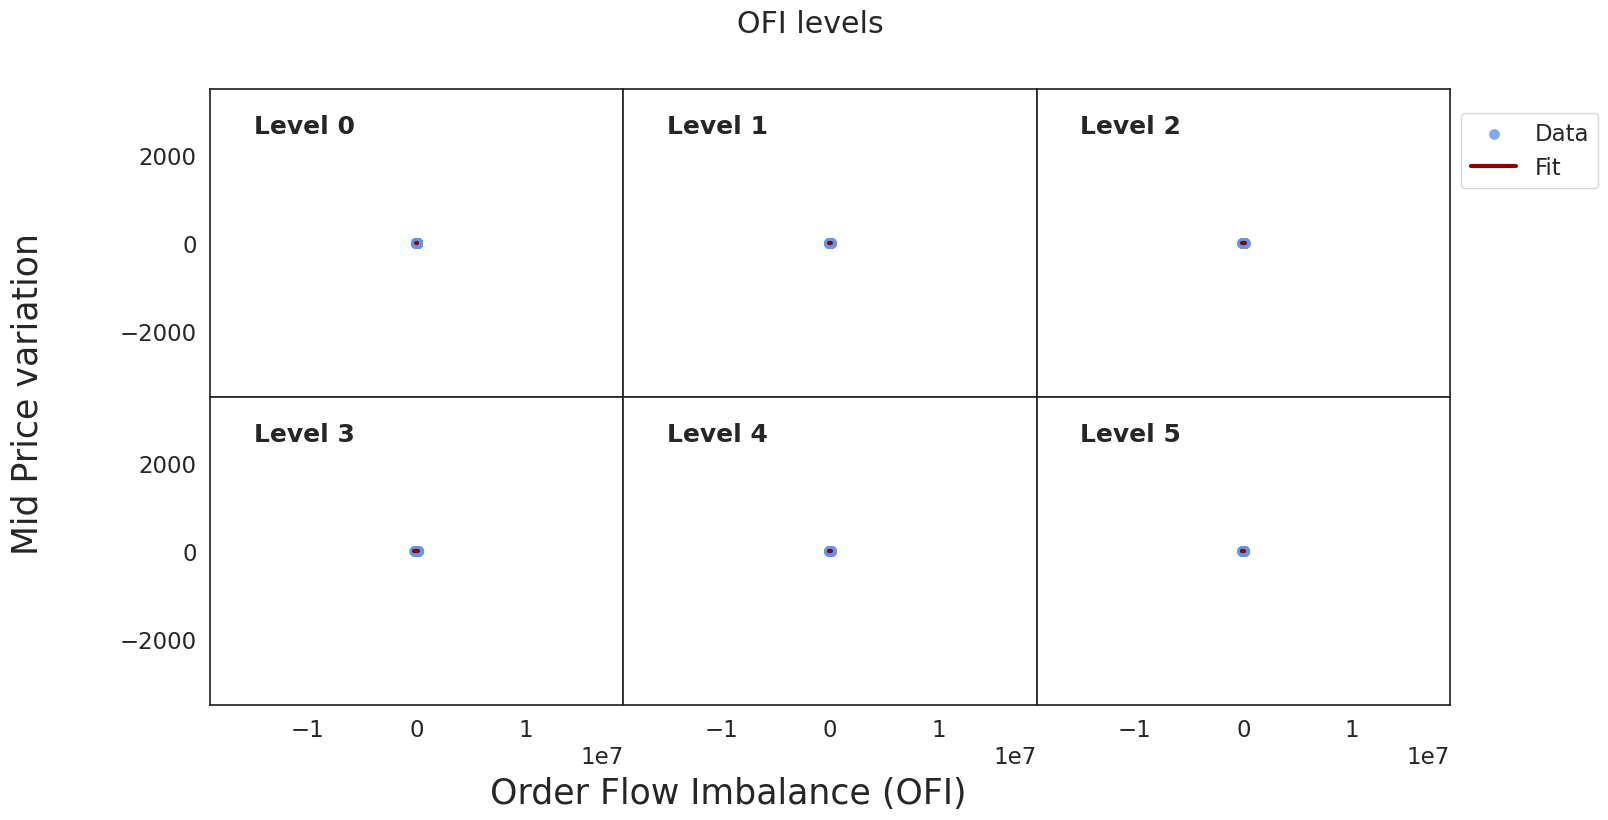

In [6]:
n_fit = 6
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
sns.set_theme(style='white', font_scale=1.5)
j=0
k=0
a_coeff, b_coeff, r2_scores  = [], [], []
for i in range(n_fit):
    print('Fitting level {}'.format(i))
    if i==3: 
        j=0
        k=1
    #removing outliers 
    trend_data = np.array([ofi['OFI_{}'.format(i)], ofi['mid_price_delta']], dtype=np.float64).T
    clf = IsolationForest(n_estimators=100)
    clf.fit(trend_data)   
    outliers = [True if x==1 else False for x in clf.predict(trend_data)]
    trend_data=trend_data[outliers].T

    # linear fit
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score, mean_squared_error
    model=Ridge()
    model.fit(trend_data[0].reshape(-1,1),trend_data[1])
    a, b = model.coef_[0], model.intercept_
    a_coeff.append(a)
    b_coeff.append(b)
    # r2_score: proportion of the variation in the dependent 
    # variable that is predictable from the independent variable
    r2_scores.append((r2_score(trend_data[1], model.predict(trend_data[0].reshape(-1,1)))))

    #plot
    predicted=[a*x+b for x in trend_data[0]]
    sns.scatterplot(x=trend_data[0], y=trend_data[1], ax=ax[k,j], \
                    s=60, marker='o', color ='cornflowerblue',linewidth=0, alpha=0.8, label='Data')
    g=sns.lineplot(x=trend_data[0], y=predicted, ax=ax[k,j], lw=3, color='darkred', label='Fit')

    g.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    if k!=0 and j!=0: ax[k,j].get_legend().remove()
    ax[k,j].set_xlabel('')
    ax[k,j].set_ylabel('')
    ax[k,j].set_xlim(-1.9e7, 1.9e7)
    ax[k,j].set_ylim(-3500, 3500)
    ax[k,j].text(-1.5e7, 2500, 'Level {}'.format(i), weight='bold')
    j+=1

#Options for the plot
fig.suptitle('OFI levels')
ax[0,0].get_shared_x_axes().join(ax[0,0], ax[1,0])
ax[0,0].set_xticklabels([])
ax[0,1].set_yticklabels('')
ax[1,1].set_yticklabels('')
ax[1,2].set_yticklabels('')
ax[0,2].set_yticklabels('')

fig.text(0, 0.5, 'Mid Price variation', rotation=90, va='center', fontsize=25)
fig.text(0.3, 0, 'Order Flow Imbalance (OFI) ', va='center', fontsize=25)
fig.subplots_adjust(hspace=.0, wspace=0.)

#output
import os 
if os.path.isdir('../figures')==False:
    os.mkdir('../figures')
fig.savefig('../figures/OFI_levels_fit.png', bbox_inches='tight')

#results
from IPython.display import display, Math
for i in range(n_fit): 
    display(Math(r'Level \,\,{} \quad \quad  \Delta \overline P = {:.10f}\,\, OFI_{} + {:.4f}'.format(i, a_coeff[i], i, b_coeff[i])+
            '\quad R^2 = {:.2f}, \quad MSE= {:.2f}'.format(r2_scores[i], 1)))

### Multi dimensional linear fit

Now that we verified that a linear relation occurs, even though the quality of the fit does not allow us to descrie all the variance of the mid price in the book, we can use the same procedure to study the OFI in the first ten levels of the book by applying a multi dimensional linear fit. Moreover, this same strategy can be also seen as the definition of a new feature as the linear combination of the multi-level OFIs.

So we propose two strategies:

1. We apply the startegy proposed by K. Xu, M. D. Gould, and S. D. Howison (Multi-Level Order-Flow Imbalance in a Limit Order Book), which consist in a multi-dimensional linear fit by means of Ridge regression of the OFI in the first ten levels of the book:$$\Delta  P_k = \alpha+ \sum_m \beta_m OFI_m^k$$
    where $P_k $ is defined as before, and OFI_m^k$ is the OFI in the $m^{th}$ level of the book at time $\tau_k$.
    
2. We define a new feature as the weighted sum of the first 10 levels OFI and we optimize the r2 score of a linear regression vs the mid price evolution of such feature. Then the weights are employed to define the feature and to perform a second linear fit: $$ f = \sum_m \beta_m OFI_m $$ $$ \Delta  P = \alpha+ \gamma f $$

The second strategy was employed to test if a multiple optimization performed by combining a gradient based method (sklearn linear regression) with a gradient free approach (powell and cobyla) could lead to better results, nevertheless results are statistically similar to the first strategy. Thus we conclude that the results do not depend on the computational strategy employed, and we can actually describe arounf 40% of the variance of the mid price in the book by means of the OFI.

In [7]:
%%time
mid_price_delta = ofi['mid_price_delta']

# linear regression with sklearn
model=Ridge()
model.fit(OFI_values, mid_price_delta)
betas, alpha = model.coef_, model.intercept_
r2_scores=r2_score(mid_price_delta, model.predict(OFI_values))

print('MULTIDIMENSIONAL LINEAR REGRESSION')
display(Math(r'\Delta P = \alpha+ \sum_m \beta_m OFI_m'))
display(Math(r'\alpha = {:.4f}'.format(alpha)))
display(Math(r'\beta =['+', \,\,'.join(['{:.6f}'.format(b) for b in betas])+']'))
display(Math(r'R^2 = {:.2f}'.format(r2_scores)))


[ 1.19086476e-01  4.24235612e-01  3.27260886e-01 -3.10625138e-01
 -2.47950740e-02  1.96696787e-03  1.26885330e-02 -1.46244214e-02
  4.66799002e-03 -1.29476670e-02  1.87982391e-02  9.65784692e-02
 -2.45069880e-01  1.68504844e-02  2.32471468e-02  3.13749365e-02
 -2.46693548e-02  7.04333339e-02  1.04158952e-01  7.25819715e-03
  5.33029505e-03  5.33029505e-03 -4.51940906e-02  6.87229622e-03
  1.08702025e-01  1.51720739e-01 -6.25646400e-02  4.49899240e-02
  7.93571070e-02  5.33029505e-03 -5.74588096e-02  1.57314917e-01
 -1.95852435e-02  4.01026282e-03  5.31359691e-02  1.91670550e-03
  1.05291686e-03  5.40778877e-02  8.22677416e-03  7.07393070e-02
  4.38267027e-02  6.80484809e-04  5.33029505e-03 -2.66027305e-02
 -6.80229196e-02  5.24626131e-02  7.49478572e-02  5.33029505e-03
 -1.39843459e-01  9.53225381e-03 -3.32722564e-03  7.35462333e-03
  3.44316155e-02 -8.22372955e-03 -5.88884834e-03  1.25845092e-02
 -3.29618259e-02  4.37224659e-02  9.36393082e-03 -6.09174774e-02
  6.23576248e-02 -3.65502

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

CPU times: user 14 ms, sys: 378 µs, total: 14.4 ms
Wall time: 12.6 ms


MULTIDIMENSIONAL LINEAR REGRESSION


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Optimization terminated successfully.
         Current function value: -0.563988
         Iterations: 4
         Function evaluations: 418
OPTIMIZATION COMBINED WITH REGRESSION


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

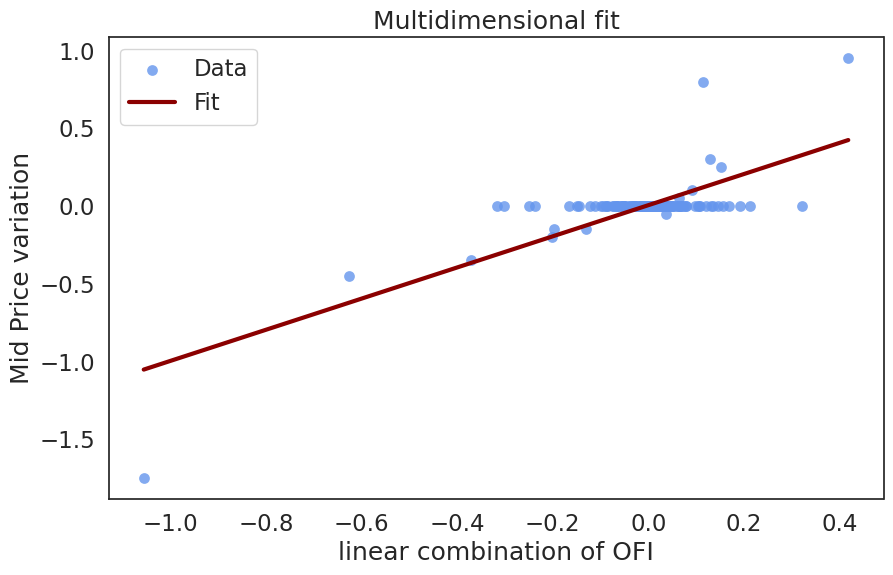

In [8]:
mid_price_delta = ofi['mid_price_delta']

# linear regression with sklearn
model=Ridge()
model.fit(OFI_values, mid_price_delta)
betas, alpha = model.coef_, model.intercept_
r2_scores=r2_score(mid_price_delta, model.predict(OFI_values))
print('MULTIDIMENSIONAL LINEAR REGRESSION')
display(Math(r'\Delta P = \alpha+ \sum_m \beta_m OFI_m'))
display(Math(r'\alpha = {:.4f}'.format(alpha)))
display(Math(r'\beta =['+', \,\,'.join(['{:.6f}'.format(b) for b in betas])+']'))
display(Math(r'R^2 = {:.2f}'.format(r2_scores)))

# TODO: 随机梯度下降算法在分钟级别的数据 半小时的窗口的情况下 直接预测e20，但实际1位数
# from sklearn.linear_model import SGDRegressor
# model2=SGDRegressor(loss='squared_epsilon_insensitive', penalty='l2')
# model2.fit(OFI_values, mid_price_delta)
# betas2, alpha2 = model.coef_, model.intercept_
# print(betas2, alpha2)
# print(model2.predict(OFI_values))
# print(mid_price_delta)
# r2_scores2=r2_score(mid_price_delta, model2.predict(OFI_values))
# print('SGD squared loss REGRESSION')
# display(Math(r'\Delta P = \alpha+ \sum_m \beta_m OFI_m'))
# display(Math(r'\alpha = {:.4f}'.format(alpha2[0])))
# display(Math(r'\beta =['+', \,\,'.join(['{:.6f}'.format(b) for b in betas2])+']'))
# display(Math(r'R^2 = {:.2f}'.format(r2_scores2)))

def linear_combination(weights, data):
        """
        args:
            weights (list or np.array): list of weights
            data (list or np.array): list of OFI
        returns:
            linear combination of data
        """
        return sum([w*d for w,d in zip(weights, data)])

sns.set_theme(style='white', font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,6))
new_feature = [linear_combination(betas, OFI_values.iloc[i,:]) for i in range(len(OFI_values))]
sns.scatterplot(x=new_feature, y=mid_price_delta, ax=ax, s=60, marker='o', 
                color ='cornflowerblue',linewidth=0, alpha=0.8, label='Data')
sns.lineplot(x=new_feature, y=alpha+new_feature, ax=ax, lw=3, color='darkred', label='Fit')
ax.set_ylabel('Mid Price variation')
ax.set_xlabel('linear combination of OFI')
ax.set_title('Multidimensional fit')


# optimization of the new feature 
def loss(weights, data_ofi, mid_price_delta):
    """
    args:
        weights: list of weights
        data_ofi: list of OFI
        mid_price_delta: list of mid price delta
    returns:
        loss of linear combination of data
    """

    if len(weights)!=len(data_ofi.columns):
        raise ValueError('weights and data_ofi.columns must have the same length')
    if len(data_ofi)!=len(mid_price_delta):
        raise ValueError('data_ofi and mid_price_delta must have the same length')

    new_feature = np.array([linear_combination(weights, data_ofi.iloc[i,:]) for i in range(len(data_ofi))])

    # We optimize over tthe weights once we defined a new feature which is the weighted sum of the OFI
    # objective is the r2 score of the linear fit

    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(new_feature.reshape(-1,1), mid_price_delta)
    r2 = r2_score(mid_price_delta, model.predict(new_feature.reshape(-1,1)))
    return -r2

from scipy.optimize import minimize
r = minimize(loss, x0=np.random.uniform(size=10), args=(OFI_values, mid_price_delta), 
        method='powell', bounds=[(0, None) for i in range(10)], options={'disp': True})

weights = r.x
new_feature = np.array([linear_combination(weights, OFI_values.iloc[i,:]) for i in range(len(OFI_values))])

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(new_feature.reshape(-1,1), mid_price_delta)
r2 = r2_score(mid_price_delta, model.predict(new_feature.reshape(-1,1)))
alpha = model.intercept_
betas = weights
gamma = model.coef_

print('OPTIMIZATION COMBINED WITH REGRESSION')
display(Math(r'\Delta  P = \alpha+ \gamma \sum_m \beta_m OFI_m'))
display(Math(r'\alpha = {:.4f}'.format(alpha)))
display(Math(r'\gamma = {:.5f}'.format(*gamma)))
display(Math(r'\beta =['+', \,\,'.join(['{:.6f}'.format(b) for b in betas])+']'))
display(Math(r'\beta*\gamma =['+', \,\,'.join(['{:.6f}'.format(b*gamma[0]) for b in betas])+']'))
display(Math(r'R^2 = {:.2f}'.format(r2)))

## PCA and correlations

Finally, since we verified that different levels of the book exhibit the same relation with the mid price time evolution, we would expect to observe correlations within different OFI. 

To formalize this, we can use the PCA to study the correlation between the OFI in the first ten levels of the book.
We then provide the correlation matrix, and the explained variance of the principal components computed after applying PCA to the data. 
We can deduce that the first four levels tend to be more correlated if compared with higher levels, while lower levels of correlations are observed in the rest of the book. The analysis of the explained variance ratio also shows that in order to explain at least the 80% of the variance of the data we should consider at least four components in the eigenvalues space.

Text(875.8863636363634, 0.5, 'Explained variance')

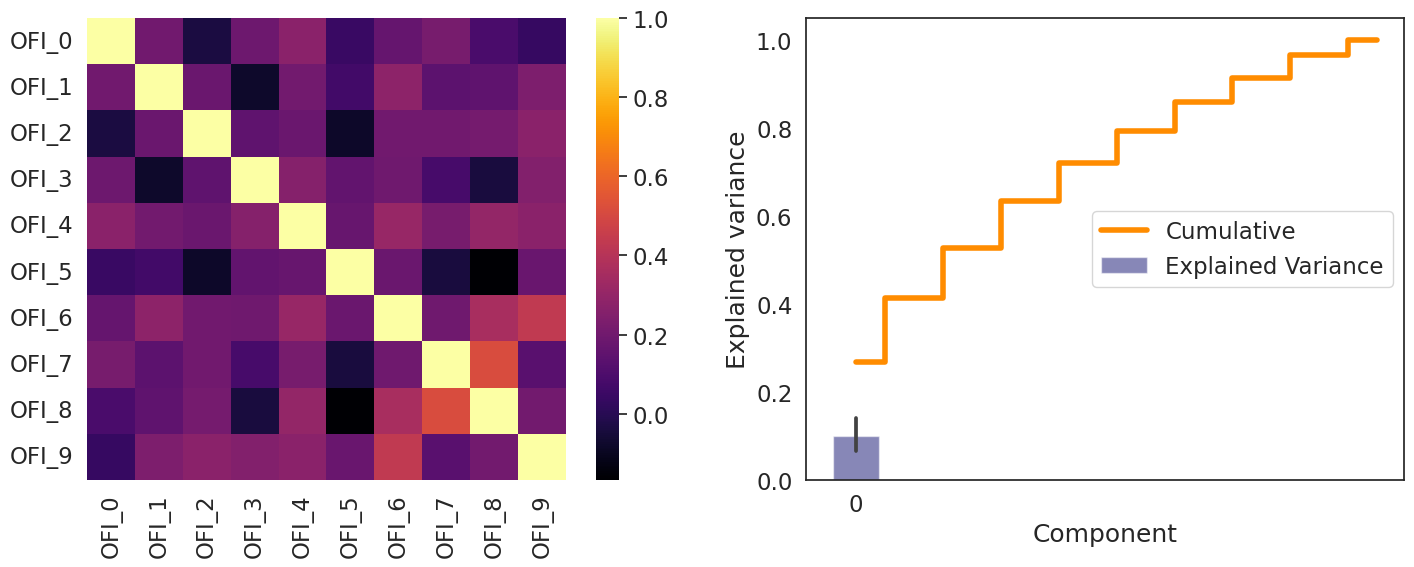

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaled = scaler.fit_transform(OFI_values) 
pca = PCA(n_components=None)
pca.fit(scaled)
new_ofi = pca.transform(scaled)

sns.set_theme(style='white', font_scale=1.5, palette = 'magma')
explained_var = pca.explained_variance_ratio_
fig, ax = plt.subplots(1,2, figsize=(17,6))

sns.barplot(data=explained_var, alpha=0.5, color = 'navy', ax=ax[1], label='Explained Variance')
ax[1].step(np.arange(len(explained_var)), np.cumsum(explained_var),\
         drawstyle='steps-pre', color='darkorange', lw=4, where = 'mid', label='Cumulative')
plt.legend(loc='center right')
sns.heatmap(OFI_values.corr(), cmap='inferno', fmt='.1f', ax=ax[0])#annot=True
ax[1].set_xlabel('Component')
ax[1].set_ylabel('Explained variance')